## run imports

In [76]:
import ingredient_preprocessor as ip
import ingredient_indexing as ingredient_indexing
from food_ranker import *
import food_indexing as food_indexing
import food_preprocessor as fp
from importlib import reload
import matplotlib.pyplot as plt

## run constants

In [77]:
STOPWORDS_PATH = 'stopwords.txt'
DATASET_PATH = 'cleanedRecipes.jsonl'
INGREDIENT_INDEX_PATH = 'ingredient_index'
FOOD_INDEX_PATH = 'food_index'
ID_TO_RECIPE_PATH = 'id_to_recipe.json'
ANNOTATED_PATH = 'annotations.csv'

## ONLY RUN THIS IF IT DOESN'T EXIST FOR YOU YET IN YOUR PROJECT DIRECTORY: build a doc id to doc info JSON for quick loading in CLI

In [3]:
id_to_recipe = {}  # make doc id to info dict for quick loading

with open(DATASET_PATH, 'r') as recipes_read:
    for recipe in recipes_read:
        recipe = json.loads(recipe)
        recipe_id = recipe['recipeID']
        recipe_title = recipe['title']
        recipe_link = recipe['link']
        recipe_NERs = recipe['NER']
        id_to_recipe[recipe_id] = (recipe_title, recipe_link, recipe_NERs)

with open(ID_TO_RECIPE_PATH, 'w') as json_out:
    json_data = json.dumps(id_to_recipe, indent=4)
    
    json_out.write(json_data)

## OR LOAD IT INSTEAD

In [4]:
with open(ID_TO_RECIPE_PATH, 'r') as json_file:
    id_to_recipe = json.load(json_file)

## build ingredient tokenizer, stopwords, food tokenizer

In [5]:
ingredient_preprocessor = ip.SplitTokenizer()
ingredient_preprocessor.tokenize("This is a test sentences, with a comma...., chicken breasts")

['this is a test sentence', 'with a comma', 'chicken breast']

In [6]:
stopwords = set()
with open(STOPWORDS_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 610'

In [7]:
# stopwords = {'and', 'the', 'or', 'is', 'for'}
food_preprocessor = fp.RegexTokenizer('\w+', lowercase=True, multiword_expressions=None)

# TRY LOADING INVERTED INDEXES FIRST

In [8]:
ingredient_index = ingredient_indexing.InvertedIndex()
ingredient_index.load(INGREDIENT_INDEX_PATH)

food_index = food_indexing.InvertedIndex()
food_index.load(FOOD_INDEX_PATH)

## OR CREATE THEM IF NOT SAVED

In [ ]:
# preprocessor = RegexTokenizer('\w+', lowercase=True, multiword_expressions=None)
ingredient_index = ingredient_indexing.Indexer.create_index(ingredient_indexing.IndexType.InvertedIndex, dataset_path=DATASET_PATH, document_preprocessor=ingredient_preprocessor, stopwords=stopwords, minimum_word_frequency=0, text_key='NER', max_docs=1000000)
print(ingredient_index.get_statistics())

In [ ]:
food_index = food_indexing.Indexer.create_index(food_indexing.IndexType.InvertedIndex, dataset_path=DATASET_PATH, document_preprocessor=food_preprocessor, stopwords=stopwords, minimum_word_frequency=10, text_key='directions', max_docs=1000000)
print(food_index.get_statistics())

In [ ]:
ingredient_index.save(INGREDIENT_INDEX_PATH)
food_index.save(FOOD_INDEX_PATH)

## run some tests

In [9]:
food_index.get_term_metadata('chicken')

{'term_freq': 77312, 'term_total_count': 168569}

In [10]:
ingredient_index.get_term_metadata('chicken')

{'term_freq': 41926, 'term_total_count': 42853}

In [11]:
ingredient_index.get_postings('king')

[[10800, 1],
 [14591, 1],
 [74649, 1],
 [251959, 1],
 [267836, 1],
 [330864, 1],
 [359552, 1],
 [436990, 1],
 [465951, 1],
 [530753, 1],
 [624002, 1],
 [657903, 1]]

In [12]:
len([word for word in ingredient_index.index.keys() if len(word.split(" ")) > 1])

54400

## build the ranker (this can run again to get edited ranker)

In [95]:
import food_ranker
reload(food_ranker)
from food_ranker import *

In [72]:
ranker = Ranker(food_index, ingredient_index, food_preprocessor, ingredient_preprocessor, stopwords, BM25, id_to_recipe)

## run some test queries

In [73]:
topq = ranker.query(query_ingr='pie, flour, cream, apples, blueberries', query_freetext='sweet and spicy pie', query_NOT='eggs, pecans, nuts, almonds')[:150]

In [74]:
topq

[(784496, 0.5),
 (227756, 0.4),
 (135972, 0.4),
 (196704, 0.4),
 (123287, 0.4),
 (568638, 0.3333333333333333),
 (73794, 0.3333333333333333),
 (949548, 0.3333333333333333),
 (283419, 0.3333333333333333),
 (556491, 0.3333333333333333),
 (584717, 0.3333333333333333),
 (221867, 0.3333333333333333),
 (373723, 0.3333333333333333),
 (725366, 0.3333333333333333),
 (117459, 0.3333333333333333),
 (309576, 0.3333333333333333),
 (113773, 0.3333333333333333),
 (843719, 0.2857142857142857),
 (217296, 0.2857142857142857),
 (318968, 0.2857142857142857),
 (432029, 0.2857142857142857),
 (539221, 0.2857142857142857),
 (341859, 0.2857142857142857),
 (24139, 0.2857142857142857),
 (383427, 0.2857142857142857),
 (293926, 0.25),
 (522343, 0.25),
 (270511, 0.25),
 (96312, 0.25),
 (625256, 0.25),
 (543038, 0.25),
 (5319, 0.25),
 (341743, 0.25),
 (889236, 0.25),
 (773604, 0.25),
 (858917, 0.2222222222222222),
 (886102, 0.2222222222222222),
 (124486, 0.2),
 (179368, 0.2),
 (495019, 0.2),
 (998806, 0.2),
 (576547,

# LET'S RUN SOME METRIC TESTS WITH OUR ANNOTATED DATA

In [94]:
import relevance
reload(relevance)

<module 'relevance' from '/Users/jonathan/git_repos/si650-final-project/relevance.py'>

In [96]:
relevance.run_relevance_tests(ANNOTATED_PATH, ranker=ranker)

  0%|          | 0/40 [00:00<?, ?it/s]

new query


  2%|▎         | 1/40 [00:03<02:31,  3.88s/it]

new query


  5%|▌         | 2/40 [00:06<02:07,  3.35s/it]

new query


  8%|▊         | 3/40 [00:09<01:52,  3.05s/it]

new query


 10%|█         | 4/40 [00:16<02:46,  4.64s/it]

new query


 12%|█▎        | 5/40 [00:18<02:11,  3.77s/it]

new query


 15%|█▌        | 6/40 [00:23<02:17,  4.04s/it]

new query


 18%|█▊        | 7/40 [00:27<02:15,  4.10s/it]

new query


 20%|██        | 8/40 [00:32<02:17,  4.31s/it]

new query


 22%|██▎       | 9/40 [00:34<01:54,  3.68s/it]

new query


 25%|██▌       | 10/40 [00:35<01:45,  3.53s/it]

[0.12222222222222223, 0.34174603174603174, 0, 0.075, 0, 0.23174603174603173, 0.5142063492063491, 0, 0.28174603174603174, 0.2595238095238095]
10


{'map': 0.1826190476190476, 'ndcg': 0.35204219237163803}

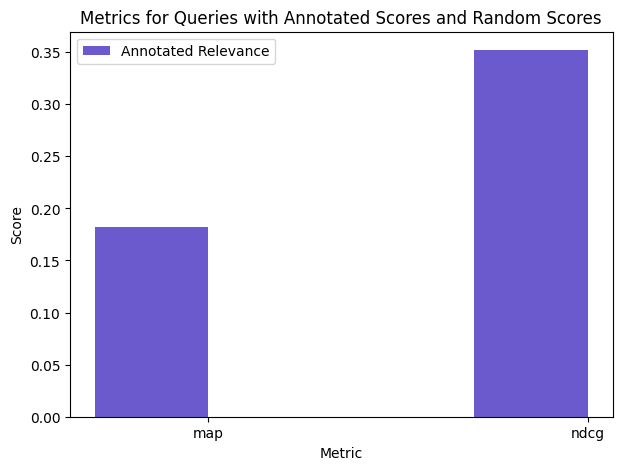

In [97]:
# PLOT
annotatedScore = {'map': 0.1826190476190476, 'ndcg': 0.35204219237163803}
categories = list(annotatedScore.keys())
values1 = list(annotatedScore.values())
#values2 = list(randomscore.values())

#increase figsize
# Define the width of the bars
bar_width = 0.3

# Create a figure and axis
fig, ax = plt.subplots()

fig.set_size_inches(7, 5)

# Set the positions for the bars
x = range(len(categories))
# y axis range below 0 to -.01

# Create the bars for data1
bars1 = plt.bar(x, values1, width=bar_width, label='Annotated Relevance', color='slateblue')

# Create the bars for data2, shifted to the right
x_shifted = [pos + bar_width for pos in x]
plt.xticks([pos + bar_width / 2 for pos in x], categories)
plt.legend(loc='upper left')

plt.ylabel('Score')
plt.xlabel('Metric')
plt.title('Metrics for Queries with Annotated Scores and Random Scores')
plt.show()